In [4]:
### 1. Imports και paths

import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import cv2
import random
from tqdm import tqdm

# Ορισμός paths (βάλε τις δικές σου διαδρομές αν είναι διαφορετικές)
train_tiles = r'C:\share\project_folder\train_images'
train_masks = r'C:\share\project_folder\train_masks'
val_tiles = r'C:\share\project_folder\val_images'
val_masks = r'C:\share\project_folder\val_masks'
test_tiles = r'C:\share\project_folder\test_images'
test_masks = r'C:\share\project_folder\test_masks'
IMG_SIZE = 512  # προσαρμόζεις αν είναι άλλο μέγεθος

In [7]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.load_model('best_model.h5', compile=False)
print("Model loaded successfully.")

Model loaded successfully.


In [8]:
class TestGenerator(tf.keras.utils.Sequence):
    def __init__(self, img_dir, mask_dir, batch_size, img_size):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.file_list = os.listdir(img_dir)

    def __len__(self):
        return int(np.ceil(len(self.file_list) / self.batch_size))

    def __getitem__(self, idx):
        batch_files = self.file_list[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_imgs = []
        batch_masks = []

        for file in batch_files:
            img_path = os.path.join(self.img_dir, file)
            mask_path = os.path.join(self.mask_dir, file)

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) / 255.0
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

            batch_imgs.append(img.reshape(self.img_size, self.img_size, 1))
            batch_masks.append(mask.reshape(self.img_size, self.img_size, 1))

        return np.array(batch_imgs), np.array(batch_masks)


In [10]:
def calculate_iou(y_true, y_pred, threshold=0.5):
    y_pred_bin = (y_pred > threshold).astype(np.uint8)
    intersection = np.sum(y_true * y_pred_bin)
    union = np.sum(y_true) + np.sum(y_pred_bin) - intersection
    if union == 0:
        return 1.0
    return intersection / union

def dice_coefficient(y_true, y_pred, threshold=0.5):
    y_pred_bin = (y_pred > threshold).astype(np.uint8)
    intersection = np.sum(y_true * y_pred_bin)
    total = np.sum(y_true) + np.sum(y_pred_bin)
    if total == 0:
        return 1.0
    return (2. * intersection) / total


In [11]:
### 4. Υπολογισμός IoU και Dice για όλο το test set

ious = []
dices = []

for file in tqdm(os.listdir(test_tiles), desc="Evaluating Test Set"):
    img_path = os.path.join(test_tiles, file)
    mask_path = os.path.join(test_masks, file)

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) / 255.0
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

    input_img = img.reshape(1, IMG_SIZE, IMG_SIZE, 1)
    pred_mask = model.predict(input_img, verbose=0)[0, :, :, 0]

    iou = calculate_iou(mask, pred_mask)
    dice = dice_coefficient(mask, pred_mask)

    ious.append(iou)
    dices.append(dice)

print(f"\nMean IoU: {np.mean(ious):.4f}")
print(f"Mean Dice: {np.mean(dices):.4f}")


Evaluating Test Set: 100%|█████████████████████████████████████████████████████████| 4862/4862 [26:00<00:00,  3.12it/s]


Mean IoU: 0.0000
Mean Dice: 0.0000


In [13]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

test_gen = TestGenerator(test_tiles, test_masks, batch_size=16, img_size=IMG_SIZE)
loss, acc = model.evaluate(test_gen)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")


304/304 [==============================] - 930s 3s/step - loss: 0.0021 - accuracy: 0.9453
Test Loss: 0.0021
Test Accuracy: 0.9453


In [16]:
# Ελεγχος εικονων 
import random

# Επιλογή τυχαίου αρχείου από το test set
sample_file = random.choice(os.listdir(test_tiles))
img_path = os.path.join(test_tiles, sample_file)
mask_path = os.path.join(test_masks, sample_file)

# Φόρτωση εικόνας και μάσκας
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) / 255.0
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

# Επεξεργασία εισόδου
input_img = img.reshape(1, IMG_SIZE, IMG_SIZE, 1)

# Πρόβλεψη μάσκας
pred_mask = model.predict(input_img, verbose=0)[0, :, :, 0]

# Εκτύπωση εύρους τιμών
print(f"Sample file: {sample_file}")
print("Predicted mask min:", pred_mask.min())
print("Predicted mask max:", pred_mask.max())


Sample file: 193_0324041235_row11_col3.tif
Predicted mask min: 1.4823298e-06
Predicted mask max: 0.025770435


In [17]:
import cv2
import numpy as np
import os
from tqdm import tqdm

# Υπολογισμός sparsity στις μάσκες του test set
total_pixels = 0
total_positive_pixels = 0

for file in tqdm(os.listdir(test_masks), desc="Υπολογισμός sparsity"):
    mask_path = os.path.join(test_masks, file)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = (mask > 127).astype(np.uint8)  # Binarization αν δεν είναι ήδη binary

    total_pixels += mask.size
    total_positive_pixels += np.sum(mask)

sparsity = (1 - (total_positive_pixels / total_pixels)) * 100

print(f"Sparsity των masks: {sparsity:.2f}%")
print(f"Μέσο ποσοστό pixels που ανήκουν στο αντικείμενο: {100 - sparsity:.2f}%")


Υπολογισμός sparsity: 100%|███████████████████████████████████████████████████████| 4862/4862 [00:27<00:00, 177.43it/s]

Sparsity των masks: 100.00%
Μέσο ποσοστό pixels που ανήκουν στο αντικείμενο: 0.00%


In [18]:
### Υπολογισμός sparsity στο train_masks

import os
import cv2
import numpy as np
from tqdm import tqdm

# Ο φάκελος με τις μάσκες του training set
train_mask_dir = train_masks

total_pixels = 0
total_positive = 0

for file in tqdm(os.listdir(train_mask_dir), desc="Υπολογισμός sparsity στα train masks"):
    mask_path = os.path.join(train_mask_dir, file)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    mask = mask / 255.0  # normalization για να πάει 0-1

    total_pixels += mask.size
    total_positive += np.sum(mask > 0.5)  # count των "θετικών" pixels

# Υπολογισμός sparsity και object ratio
sparsity = 100 * (1 - total_positive / total_pixels)
object_ratio = 100 * (total_positive / total_pixels)

# Εκτύπωση αποτελεσμάτων
print(f"Sparsity των train masks: {sparsity:.2f}%")
print(f"Μέσο ποσοστό pixels που ανήκουν στο αντικείμενο: {object_ratio:.2f}%")


Υπολογισμός sparsity στα train masks: 100%|██████████████████████████████████████| 22684/22684 [06:09<00:00, 61.43it/s]

Sparsity των train masks: 100.00%
Μέσο ποσοστό pixels που ανήκουν στο αντικείμενο: 0.00%


In [20]:
### Ορισμός του DataGenerator

class DataGenerator(keras.utils.Sequence):
    def __init__(self, image_dir, mask_dir, batch_size=16, img_size=512, max_samples=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.image_files = os.listdir(image_dir)
        if max_samples:
            self.image_files = self.image_files[:max_samples]
        self.indexes = np.arange(len(self.image_files))
        
    def __len__(self):
        return int(np.ceil(len(self.image_files) / self.batch_size))
    
    def __getitem__(self, index):
        batch_files = self.image_files[index*self.batch_size:(index+1)*self.batch_size]
        batch_imgs = []
        batch_masks = []
        for file in batch_files:
            img_path = os.path.join(self.image_dir, file)
            mask_path = os.path.join(self.mask_dir, file)
            
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) / 255.0
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0
            
            img = img.reshape(self.img_size, self.img_size, 1)
            mask = mask.reshape(self.img_size, self.img_size, 1)
            
            batch_imgs.append(img)
            batch_masks.append(mask)
        
        return np.array(batch_imgs), np.array(batch_masks)

### Δημιουργία του generator μόνο για τα 500 samples του training
train_gen = DataGenerator(train_tiles, train_masks, max_samples=500)

### Υπολογισμός sparsity

total_pixels = 0
object_pixels = 0

for i in tqdm(range(len(train_gen)), desc="Υπολογισμός sparsity στα training samples"):
    _, batch_masks = train_gen[i]
    total_pixels += np.prod(batch_masks.shape)
    object_pixels += np.sum(batch_masks > 0.5)

sparsity = 100.0 * (1 - object_pixels / total_pixels)
object_percentage = 100.0 * object_pixels / total_pixels

print(f"Sparsity των training masks: {sparsity:.2f}%")
print(f"Μέσο ποσοστό pixels που ανήκουν στο αντικείμενο: {object_percentage:.2f}%")


Υπολογισμός sparsity στα training samples: 100%|███████████████████████████████████████| 32/32 [00:20<00:00,  1.54it/s]

Sparsity των training masks: 100.00%
Μέσο ποσοστό pixels που ανήκουν στο αντικείμενο: 0.00%


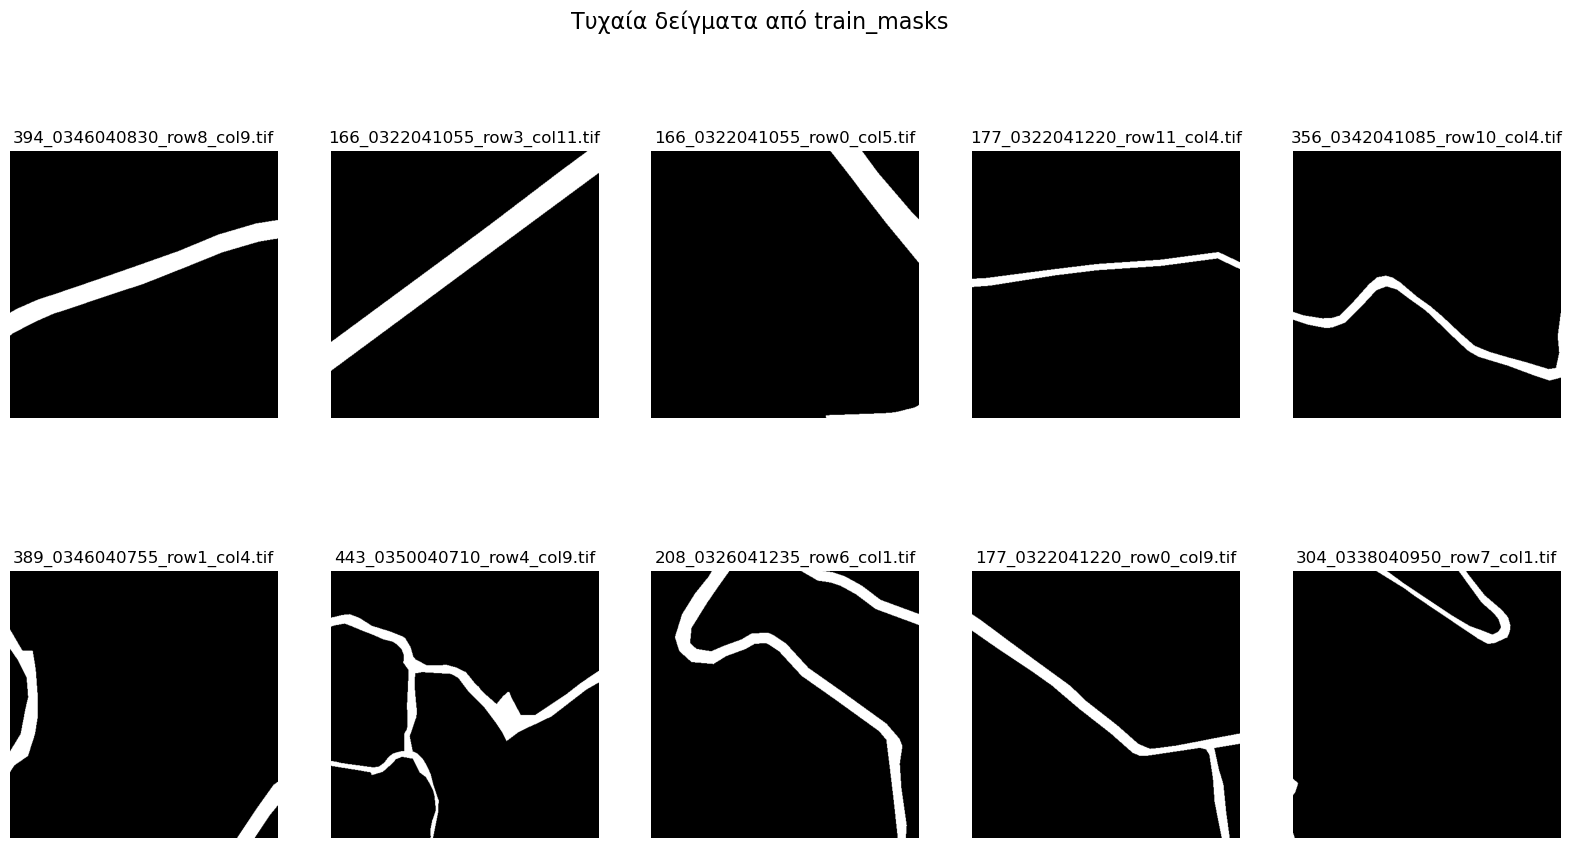

In [5]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Ορισμός path
train_masks = r'C:\share\project_folder\train_masks'

# Παίρνουμε 10 τυχαία αρχεία από το train_masks
sample_files = random.sample(os.listdir(train_masks), 10)

plt.figure(figsize=(20, 10))

for idx, file in enumerate(sample_files):
    mask_path = os.path.join(train_masks, file)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    plt.subplot(2, 5, idx + 1)
    plt.imshow(mask, cmap='gray')
    plt.title(file)
    plt.axis('off')

plt.suptitle("Τυχαία δείγματα από train_masks", fontsize=16)
plt.show()


In [ ]:
from tqdm import tqdm

ious = []
dices = []

sample_files = random.sample(os.listdir(test_tiles), 200)  # 200 τυχαίες εικόνες

for file in tqdm(sample_files, desc="Evaluating Subset"):
    img_path = os.path.join(test_tiles, file)
    mask_path = os.path.join(test_masks, file)

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) / 255.0
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

    input_img = img.reshape(1, IMG_SIZE, IMG_SIZE, 1)
    pred_mask = model.predict(input_img, verbose=0)[0, :, :, 0]

    iou = calculate_iou(mask, pred_mask)
    dice = dice_coefficient(mask, pred_mask)

    ious.append(iou)
    dices.append(dice)

print(f"Subset Mean IoU: {np.mean(ious):.4f}")
print(f"Subset Mean Dice: {np.mean(dices):.4f}")


Model loaded successfully.
Predicted mask min: 0.000001
Predicted mask max: 0.032038


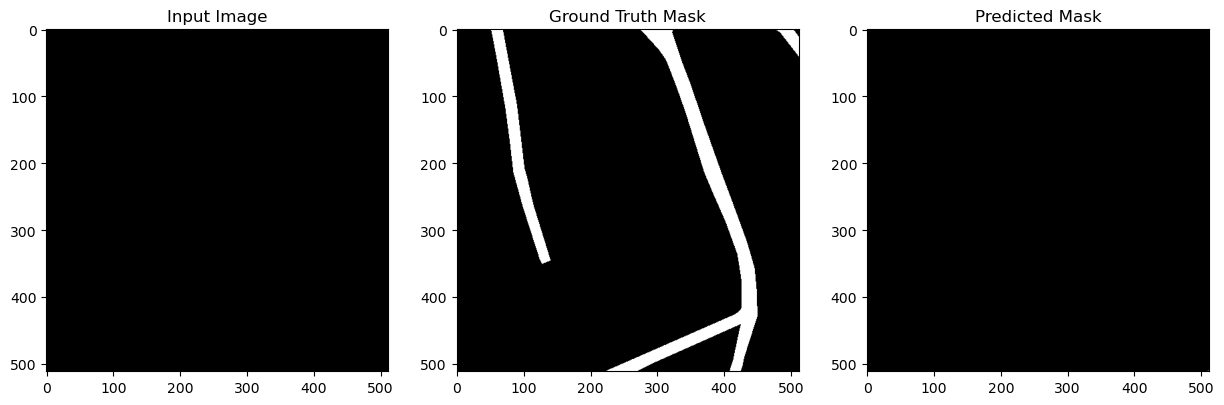

In [10]:
# Βασικά imports
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from tensorflow import keras

# Ορισμός paths
train_tiles = r'C:\share\project_folder\train_images'
train_masks = r'C:\share\project_folder\train_masks'
val_tiles = r'C:\share\project_folder\val_images'
val_masks = r'C:\share\project_folder\val_masks'
test_tiles = r'C:\share\project_folder\test_images'
test_masks = r'C:\share\project_folder\test_masks'

# Μέγεθος εικόνας
IMG_SIZE = 512

# Φόρτωση εκπαιδευμένου μοντέλου
model = keras.models.load_model('best_model.h5', compile=False)
print("Model loaded successfully.")

# Παίρνουμε ένα τυχαίο αρχείο από το train set
random_file = random.choice(os.listdir(train_tiles))
img_path = os.path.join(train_tiles, random_file)
mask_path = os.path.join(train_masks, random_file)

# Φόρτωση εικόνας και μάσκας
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) / 255.0
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

# Reshape όπως στο training
input_img = img.reshape(1, IMG_SIZE, IMG_SIZE, 1)

# Κάνουμε prediction
pred_mask = model.predict(input_img, verbose=0)[0, :, :, 0]

# Τυπώνουμε range προβλέψεων
print(f"Predicted mask min: {pred_mask.min():.6f}")
print(f"Predicted mask max: {pred_mask.max():.6f}")

# Οπτικοποίηση
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Input Image")
plt.imshow(img, cmap='gray')

plt.subplot(1,3,2)
plt.title("Ground Truth Mask")
plt.imshow(mask, cmap='gray')

plt.subplot(1,3,3)
plt.title("Predicted Mask")
plt.imshow(pred_mask, cmap='gray')

plt.show()


In [11]:
import os
import numpy as np
import cv2
import random
from tqdm import tqdm

### 1️⃣ Ορισμός paths (πρόσεξε: paths όπως στο training σου)

train_tiles = r'C:\share\project_folder\train_images'
train_masks = r'C:\share\project_folder\train_masks'
IMG_SIZE = 512  # ίδιο με training

### 2️⃣ Επιλογή των 500 training samples που χρησιμοποίησες

random.seed(42)  # σταθερότητα επιλογής
train_files = random.sample(os.listdir(train_tiles), 500)

### 3️⃣ Ορισμός συναρτήσεων IoU και Dice (όπως πριν)

def calculate_iou(y_true, y_pred, threshold=0.5):
    y_pred_bin = (y_pred > threshold).astype(np.uint8)
    intersection = np.sum(y_true * y_pred_bin)
    union = np.sum(y_true) + np.sum(y_pred_bin) - intersection
    if union == 0:
        return 1.0
    return intersection / union

def dice_coefficient(y_true, y_pred, threshold=0.5):
    y_pred_bin = (y_pred > threshold).astype(np.uint8)
    intersection = np.sum(y_true * y_pred_bin)
    total = np.sum(y_true) + np.sum(y_pred_bin)
    if total == 0:
        return 1.0
    return (2. * intersection) / total

### 4️⃣ Υπολογισμός IoU/Dice για τα 500 training samples

ious = []
dices = []

for file in tqdm(train_files, desc="Evaluating on 500 training samples"):
    img_path = os.path.join(train_tiles, file)
    mask_path = os.path.join(train_masks, file)

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) / 255.0
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

    input_img = img.reshape(1, IMG_SIZE, IMG_SIZE, 1)
    pred_mask = model.predict(input_img, verbose=0)[0, :, :, 0]

    iou = calculate_iou(mask, pred_mask)
    dice = dice_coefficient(mask, pred_mask)

    ious.append(iou)
    dices.append(dice)

print(f"\nMean IoU on 500 training samples: {np.mean(ious):.4f}")
print(f"Mean Dice on 500 training samples: {np.mean(dices):.4f}")


Evaluating on 500 training samples: 100%|████████████████████████████████████████████| 500/500 [03:30<00:00,  2.37it/s]


Mean IoU on 500 training samples: 0.0000
Mean Dice on 500 training samples: 0.0000


In [4]:
# υπολογισμοσ sparsity
import os
import numpy as np
import cv2
from tqdm import tqdm

# Δηλώνουμε τα paths (αν δεν τα έχεις ήδη δηλώσει πιο πριν)
train_tiles = r'C:\share\project_folder\train_images'
train_masks = r'C:\share\project_folder\train_masks'
val_tiles = r'C:\share\project_folder\val_images'
val_masks = r'C:\share\project_folder\val_masks'
test_tiles = r'C:\share\project_folder\test_images'
test_masks = r'C:\share\project_folder\test_masks'
IMG_SIZE = 512

# Γενική συνάρτηση sparsity
def calculate_sparsity(mask_folder, max_samples=None):
    mask_files = os.listdir(mask_folder)
    if max_samples:
        mask_files = mask_files[:max_samples]

    total_pixels = 0
    object_pixels = 0

    for file in tqdm(mask_files, desc=f"Υπολογισμός sparsity σε {mask_folder}"):
        mask_path = os.path.join(mask_folder, file)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0
        total_pixels += mask.size
        object_pixels += np.sum(mask)

    sparsity = 100 * (1 - object_pixels / total_pixels)
    positive_percentage = 100 * (object_pixels / total_pixels)

    return sparsity, positive_percentage

# Εκτελούμε για όλα τα sets:

print("\n--- Sparsity στο TRAIN SET (500 samples του training generator) ---")
train_sparsity, train_positive = calculate_sparsity(train_masks, max_samples=500)
print(f"Sparsity: {train_sparsity:.2f}%, Positive pixels: {train_positive:.4f}%")

print("\n--- Sparsity στο VALIDATION SET (100 samples) ---")
val_sparsity, val_positive = calculate_sparsity(val_masks, max_samples=100)
print(f"Sparsity: {val_sparsity:.2f}%, Positive pixels: {val_positive:.4f}%")

print("\n--- Sparsity στο TEST SET (όλο) ---")
test_sparsity, test_positive = calculate_sparsity(test_masks)
print(f"Sparsity: {test_sparsity:.2f}%, Positive pixels: {test_positive:.4f}%")



--- Sparsity στο TRAIN SET (500 samples του training generator) ---


Υπολογισμός sparsity σε C:\share\project_folder\train_masks: 100%|███████████████████| 500/500 [00:12<00:00, 41.44it/s]


Sparsity: 99.98%, Positive pixels: 0.0195%

--- Sparsity στο VALIDATION SET (100 samples) ---


Υπολογισμός sparsity σε C:\share\project_folder\val_masks: 100%|█████████████████████| 100/100 [00:01<00:00, 51.90it/s]


Sparsity: 99.98%, Positive pixels: 0.0180%

--- Sparsity στο TEST SET (όλο) ---


Υπολογισμός sparsity σε C:\share\project_folder\test_masks: 100%|██████████████████| 4862/4862 [01:33<00:00, 51.82it/s]

Sparsity: 99.98%, Positive pixels: 0.0214%
